<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/12_CustomModelsWithTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12. 텐서플로를 사용한 사용자 정의 모델과 훈련

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(33)
tf.random.set_seed(33)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 02. 넘파이처럼 텐서플로 사용하기

### 2-1. 텐서와 연산

#### 텐서

In [ ]:
tf.constant([[1., 2., 3.], [4., 5., 6.,]]) # matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [ ]:
t.dtype

tf.float32

#### 인덱싱

In [ ]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

#### 연산

In [ ]:
t + 10          # element-wise

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
tf.add(t, 10)   # same as below

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
tf.square(t)        # element-wise

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [ ]:
t @ tf.transpose(t) # matrix multiplication

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [ ]:
tf.matmul(t, tf.transpose(t))   # same as below

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

일부 함수는 numpy와 이름이 다릅니다.
- `tf.reduce_sum()`, `tf.reduce_mean()`, `tf.reduce_max()`, `tf.math.log()`
    - : `np.sum()`, `np.mean()`, `np.max()`, `np.log()`와 같지만 reduce 알고리즘을 사용
- `tf.transpose()`
    - 전치된 데이터의 복사본이 아닌 전치된 뷰view이기 때문에 `t.T`로 쓸 수 없음

#### keras.backend
Karas API는 keras.backend에 자체적인 저수준 API를 가지고 있습니다.\
square(), exp(), sqrt() 등 연산을 위한 함수가 포함됩니다.\
다른 케라스 구현에 적용하기 위한 코드를 작성할 때에는 keras.backend의 함수를 사용해야 합니다.

In [ ]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 2-2. 텐서와 넘파이
텐서와 넘파이는 서로 변환할 수 있고, \
텐서에 넘파이 연산을, 넘파이 배열에 텐서플로 연산을 사용할 수 있습니다.

In [ ]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [ ]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [ ]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 2-3. 타입 변환
텐서플로는 자동으로 타입을 변환하지 않으며, 타입이 다른 텐서는 서로 연산할 수 없습니다.\
`2.`과 같이 소수점을 포함한 텐서는 기본적으로 32비트 실수이며, 강제로 변환하기 전에는 64비트 실수와 연산할 수 없습니다.

In [ ]:
tf.constant(2.) + tf.constant(40)       # error

InvalidArgumentError: ignored

In [ ]:
tf.constant(2.) + tf.constant(40., dtype=tf.float64)    # error

InvalidArgumentError: ignored

In [ ]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)          # type casting

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 2-4. 변수
`tf.tensor()`는 텐서의 내용을 변경할 수 없기 때문에 신경망의 가중치 등 업데이트가 필요한 구조를 구현할 수 없습니다.\
`tf.Variable()`은 `assign()` 메서드를 통해 텐서의 내용을 변경할 수 있습니다.

In [ ]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [ ]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

단 케라스에서는 주로 add_weight() 메서드로 변수 생성을 대신 처리하므로 변수를 직접 생성하는 일은 거의 없습니다.

### 2-5. 다른 데이터 구조
- sparse tensor
- tensor array
- ragged tensor
- string tensor
- set
- queue

## 03. 사용자 정의 모델과 훈련 알고리즘

### 3-1. 사용자 정의 손실 함수

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=33
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=33
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

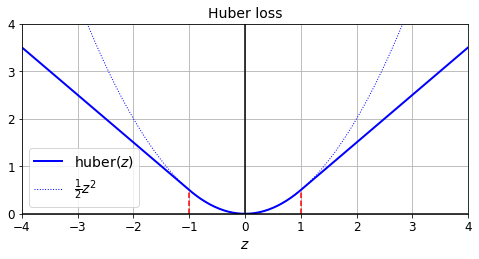

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color="k")
plt.gca().axvline(x=0, color="k")
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 6s 9ms/step - loss: 0.5967 - mae: 0.9580 - val_loss: 0.2361 - val_mae: 0.5422
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.2217 - mae: 0.5165 - val_loss: 0.2190 - val_mae: 0.5150


### 3-2. 사용자 정의 요소를 가진 모델을 저장하고 로드하기
일반적으로 사용자 정의 객체를 포함한 모델을 로드할 때는 그 이름과 객체를 매핑해야 합니다.

In [ ]:
model.save("my_model_with_a_custom_loss.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))        # continue training

Epoch 1/2
363/363 [==============================] - 6s 11ms/step - loss: 0.2080 - mae: 0.4974 - val_loss: 0.2101 - val_mae: 0.5019
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.2003 - mae: 0.4869 - val_loss: 0.2078 - val_mae: 0.4980


huber loss에서 "작은 오차"의 기준이 되는 임계점을 매개변수로 받을 수 있도록 하는 방법은 2가지가 있습니다.\
첫 번째로는 매개변수를 받을 수 있는 함수를 만드는 것입니다.

In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn
model.compile(loss=create_huber(2.0), optimizer="nadam")

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 5s 7ms/step - loss: 0.2239 - val_loss: 0.2332
Epoch 2/2
363/363 [==============================] - 3s 9ms/step - loss: 0.2193 - val_loss: 0.2314


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn":create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 9s 18ms/step - loss: 0.2174 - val_loss: 0.2269
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.2152 - val_loss: 0.2251


이 방법은 매개변수를 모델과 함께 저장하지 않기 때문에, 모델을 불러올 때마다 매개변수를 새로 지정해야 합니다.\
대신 keras.losses.Loss 클래스를 상속하여 get_config() 메서드를 구현하여 해결할 수 있습니다.

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 5s 7ms/step - loss: 0.8667 - mae: 0.9967 - val_loss: 0.2695 - val_mae: 0.5434
Epoch 2/2
363/363 [==============================] - 3s 8ms/step - loss: 0.2506 - mae: 0.5159 - val_loss: 0.2499 - val_mae: 0.5161


In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2397 - mae: 0.5048 - val_loss: 0.2452 - val_mae: 0.5150
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2338 - mae: 0.4979 - val_loss: 0.2387 - val_mae: 0.5031


In [ ]:
model.loss.threshold

2.0

###3-3. 활성화 함수, 초기화, 규제, 제한을 커스터마이징하기

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
def my_softplus(z):     # tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):       # tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 5s 9ms/step - loss: 1.6677 - mae: 0.8834 - val_loss: 0.6807 - val_mae: 0.5486
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.6081 - mae: 0.5221 - val_loss: 0.5799 - val_mae: 0.5105


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
        "my_l1_regularizer": my_l1_regularizer,
        "my_positive_weights": my_positive_weights,
        "my_glorot_initializer": my_glorot_initializer,
        "my_softplus": my_softplus,
    })

저장해야 할 하이퍼파라미터가 있는 경우,\
손실 함수와 마찬가지로 다른 사용자 정의 함수도 클래스를 상속하여 생성할 수 있습니다.

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 6s 12ms/step - loss: 1.7844 - mae: 0.9056 - val_loss: 0.7229 - val_mae: 0.5494
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.6388 - mae: 0.5267 - val_loss: 0.5989 - val_mae: 0.5148


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
        "MyL1Regularizer": MyL1Regularizer,
        "my_positive_weights": my_positive_weights,
        "my_glorot_initializer": my_glorot_initializer,
        "my_softplus": my_softplus,
    })

### 3-4. 사용자 정의 지표
손실과 지표는 개념적으로 다른 것은 아니므로, 사용자 정의 지표는 대부분 사용자 손실 함수를 만드는 것과 동일합니다.

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 3.2302 - huber_fn: 1.0206
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.9518 - huber_fn: 0.3074


In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.1516 - huber_fn: 0.2853
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1380 - huber_fn: 0.2624


In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.15160056948661804, 0.14186813833672346)

손실과 지표에 같은 함수를 사용해도 다른 결과가 나올 수 있습니다.\
이는 일반적으로 부동 소수점 정밀도 오차가 원인이지만, 연산 순서의 영향도 있습니다.
- 에포크에서 손실은 지금까지 본 모든 배치 손실의 평균입니다. 각 배치 손실은 가중치가 적용된 샘플 손실의 합을 (샘플 가중치의 합이 아닌) 배치 크기로 나눈 것입니다.
- 에포크에서 지표는 가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 샘플 가중치의 합으로 나눈 것입니다. (= 모든 샘플 손실의 가중 평균)

따라서 에포크에서 손실과 지표는 같지 않습니다.

#### 스트리밍 지표

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])   # update

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(*kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)

# total  = 2 * | 10 - 2 | - 2^2 / 2 = 14
# count  = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
# total  = total + (|1 - 0|^2 / 2) + (2 * |9.25 - 5| - 2^2 / 2) = 14 + 7 = 21
# count  = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [ ]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [ ]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.9746 - huber_metric: 0.9746
Epoch 2/2
363/363 [==============================] - 2s 6ms/step - loss: 0.2819 - huber_metric: 0.2819


In [ ]:
model.metrics[-1].threshold

2.0

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name="HuberMetric", dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 4s 4ms/step - loss: 0.4307 - HuberMetric: 0.8662
Epoch 2/2
363/363 [==============================] - 2s 7ms/step - loss: 0.1456 - HuberMetric: 0.2927


In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.4307115375995636, 0.4307117347344329)

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.2497 - HuberMetric: 0.2497
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2345 - HuberMetric: 0.2345


In [ ]:
model.metrics[-1].threshold

2.0

### 3-5. 사용자 정의 층

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 3s 7ms/step - loss: 6.4057 - val_loss: 5.6237
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 5.5763 - val_loss: 5.6237
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 5.5763 - val_loss: 5.6237
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 5.5763 - val_loss: 5.6237
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 5.6775


5.677495956420898

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)            # must be at the end
    
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units":self.units,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 7s 9ms/step - loss: 1.9966 - val_loss: 0.7583
Epoch 2/2
162/162 [==============================] - 1s 3ms/step - loss: 0.5503


0.5502800941467285

In [ ]:
model.save("my_model_with_a_custom_layer.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape, " X2.shape: ", X2.shape)
        return X1 + X2, X1 * X2
    
    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [ ]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [ ]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation="selu")(hidden_A)
hidden_B = keras.layers.Dense(30, activation="selu")(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [ ]:
model.compile(loss="mse", optimizer="nadam")

In [ ]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 7s 12ms/step - loss: 1.8503 - val_loss: 0.9706
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.9478 - val_loss: 0.9369


In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 4s 6ms/step - loss: 2.5736 - val_loss: 0.8357
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.8439


0.8438808917999268

### 3-6. 사용자 정의 모델

In [ ]:
X_new_scaled = X_test_scaled

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal") 
                       for _ in range(n_layers)]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
    
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 8s 7ms/step - loss: 4.9603
Epoch 2/5
363/363 [==============================] - 3s 7ms/step - loss: 1.3088
Epoch 3/5
363/363 [==============================] - 3s 7ms/step - loss: 1.3032
Epoch 4/5
363/363 [==============================] - 4s 10ms/step - loss: 0.9640
Epoch 5/5
162/162 [==============================] - 1s 6ms/step


In [ ]:
model.save("my_custom_model.ckpt")

In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 10s 8ms/step - loss: 0.7267
Epoch 2/5
363/363 [==============================] - 3s 7ms/step - loss: 0.6207
Epoch 3/5
363/363 [==============================] - 3s 8ms/step - loss: 0.4803
Epoch 4/5
363/363 [==============================] - 3s 9ms/step - loss: 0.5224
Epoch 5/5
363/363 [==============================] - 4s 10ms/step - loss: 0.3934


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 12s 8ms/step - loss: 0.9747
Epoch 2/5
363/363 [==============================] - 4s 10ms/step - loss: 0.5910
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4726
Epoch 4/5
363/363 [==============================] - 2s 6ms/step - loss: 0.4893
Epoch 5/5
162/162 [==============================] - 0s 2ms/step


### 3-7. 모델 구성 요소에 기반한 손실과 지표

In [ ]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal") 
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")
    
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
    
    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        if training:
            result = self.reconstruction_mean(self.recon_loss)
            self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {m.name: m.result() for m in self.metrics}

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 5s 4ms/step - loss: 0.7448 - reconstruction_error: 0.0000e+00
Epoch 2/2
162/162 [==============================] - 1s 3ms/step


### 3-8. 자동 미분을 사용하여 그레이디언트 계산하기
`tf.GradientTape` 블럭은 자동 미분 시 블록 안의 변수와 관련된 모든 연산을 자동으로 기록합니다.\
이를 활용해서 그레이디언트를 계산할 수 있습니다.

In [ ]:
def f(x1, x2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [ ]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

0.0

In [ ]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

0.0

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    x = f(w1, w2)

gradients = tape.gradient(x, [w1, w2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

`tf.GradientTape`는 `gradient()` 메서드가 호출된 후에는 자동으로 지워집니다.\
메서드를 한 번 이상 호출해야 한다면 `persistent=True`로 설정한 뒤 tape를 삭제하여 리소스를 해제해야 합니다.

In [ ]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
del tape

In [ ]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

tape는 변수가 포함된 연산만을 기록하므로 변수가 아닌 다른 객체들에 대한 `z`의 그레이디언트는 `None`으로 반환됩니다.\
`tape.watch()` 메서드를 사용하면 어떤 텐서라도 연산을 기록하고 그레이디언트를 계산할 수 있습니다.

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[None, None]

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)
    
gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[None, None]

In [ ]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    
tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=108.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [ ]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [ ]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

신경망의 일부분에 그레이디언트가 역전파되지 않도록 막기 위해서는 `tf.stop_gradient()` 함수를 사용합니다.

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

데코레이터를 사용하면 그레이디언트 계산 시 부동 소수점 문제 없는 안전한 함수를 사용하도록 만들 수 있습니다.

In [ ]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [ ]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [ ]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [ ]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [ ]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [ ]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

### 3-9. 사용자 정의 훈련 반복
`fit()` 메서드를 사용할 수 없는 특수한 경우라면 사용자 정의 훈련 반복을 사용할 수 있습니다.\
다만, 일반적인 경우 `fit()` 메서드를 사용하는 것이 좋습니다.

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) 
                          for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [ ]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [ ]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [ ]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:4f}".format(m.name, m.result()) 
                          for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [ ]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.089984 - mean_square: 858.500000


In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [ ]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.082568 - mean_absolute_error: 0.592080
Epoch 2/5
11610/11610 [==============================] - mean: 0.693288 - mean_absolute_error: 0.545637
Epoch 3/5
11610/11610 [==============================] - mean: 0.701887 - mean_absolute_error: 0.553886
Epoch 4/5
11610/11610 [==============================] - mean: 0.681696 - mean_absolute_error: 0.543995
Epoch 5/5
11610/11610 [==============================] - mean: 0.665358 - mean_absolute_error: 0.536753


In [ ]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 04. 텐서플로 함수와 그래프

In [ ]:
def cube(x):
    return x ** 3

In [ ]:
cube(2)

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
tf_cube = tf.function(cube)
tf_cube

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

#### TF 함수와 콘크리트 함수

In [ ]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [ ]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

#### 함수 정의와 그래프

In [ ]:
concrete_function.graph

In [ ]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [ ]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [ ]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [ ]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [ ]:
concrete_function.function_def.signature

name: "__inference_cube_1636262"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### 4-1. 오토그래프와 트레이싱
파이썬 함수의 소스 코드를 분석하여 `for`, `while`, `if`, `break`, `continue`, `return` 등 제어문을 모두 찾는 과정을 오토그래프라고 합니다.

In [ ]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [ ]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [ ]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]]))                          # New shape: trace
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))                 # New shape: trace
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]]))    # New shape: trace

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("traicing", images)
    return images[:, ::2, ::2]      # drop half of columns and rows

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)   # trace a function
preprocessed_images = shrink(img_batch_2)   # reuse a same concrete function

traicing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [ ]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.81242037 0.78254724]
  [0.18455112 0.34126437]]

 [[0.8010037  0.88123333]
  [0.65228796 0.44861484]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


#### 오토그래프를 사용해 제어 흐름 나타내기

In [ ]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [ ]:
add_10(tf.constant(5))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [ ]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 자원 다루기

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [ ]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [ ]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [ ]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)
    
    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [ ]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [ ]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

#### tf.keras와 TF 함수를 함께 사용하거나 사용하지 않기
tf.keras는 자동으로 사용자 정의 코드를 TF 함수로 변환하므로 `tf.function()`을 사용할 필요가 없습니다.

In [ ]:
def my_mse(y_true, y_pred):
    print("my_mse() loss tracing")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
def my_mae(y_true, y_pred):
    print("my_mae() metric tracing")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                      shape=(input_shape[1], self.units),
                                      initializer="uniform",
                                      trainable=True)
        self.biases = self.add_weight(name="bias",
                                      shape=(self.units,),
                                      initializer="zeros",
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() tracing")
        return self.activation(X @ self.kernel + self.biases)

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() tracing")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
356/363 [============================>.] - ETA: 0s - loss: 1.3898 - my_mae: 0.8174MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
363/363 [==============================] - 6s 8ms/step - loss: 1.3715 - my_mae: 0.8107 - val_loss: 0.4997 - val_my_mae: 0.4991
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.4241 - my_mae: 0.4604


[0.4241397976875305, 0.4603877663612366]

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = MyModel(dynamic=True)

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_train_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing


[5.343099117279053, 2.0971951484680176]

In [ ]:
keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing
MyModel.call() tracing
MyDense.call() tracing
MyDense.call() tracing
MyDense.call() tracing
my_mse() loss tracing
my_mae() metric tracing


[5.325292587280273, 2.107851505279541]